In [63]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import import_functions as ifunc
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
import keras


def globalVariableDefine():
    global start, end, window, per, epochs, dropout
    start=1000 # How many days back the backtesting data set should start
    end=50 # How many days back the backtesting data set should end, 0 would be today
    window=30 # Size of lookback period in predicting subsequent day, for example window = 30 means we use the past 30 trading days to predict the 31st day
    per=0.9 # Percent of data set to use as training, the rest will be used to test the model
    epochs = 100
    dropout = 0.2

    global training_set_scaled, training_set, all_data, df, sc,sc1
    sc = MinMaxScaler(feature_range = (0, 1))
    sc1 = MinMaxScaler(feature_range = (0, 1))
    # User defines which features to use for training
    use_Close = 1
    use_Adj_Close = 0
    use_Open = 0
    use_High = 0
    use_Low = 0
    use_Volume = 0
    use_MACD = 0
    use_Signal_Line = 0
    use_MACD_Crossover = 0
    use_RSI_EWMA = 0
    use_Daily_Change = 0
    use_5_Day_Change = 0

    training_set_scaled, training_set, all_data = dataImport(use_MACD, use_Close, use_Adj_Close, use_Open, use_Volume, use_Signal_Line, use_MACD_Crossover, use_RSI_EWMA, use_High, use_Low, use_Daily_Change, use_5_Day_Change)

    return training_set_scaled, training_set, all_data

def processData(training_set, training_set_scaled):
    # Creating a data structure with 60 timesteps and 1 output
    global xdata, ydata
    xdata= []
    ydata = []
    length=training_set_scaled.shape[0]-1
    column_idx = training_set_scaled.columns.get_loc('Close')
    training_set_scaled = np.array(training_set_scaled)
    training_set = np.array(training_set)

    for i in range(window, length):
        xdata.append(training_set_scaled[i-window:i,:])
        ydata.append(training_set_scaled[i+1, column_idx]) # we may need to add +1

    xdata, ydata = np.array(xdata), np.array(ydata)


    split=int(per*len(xdata))
    X_test=xdata[split:,:]
    Y_test=ydata[split:]
    test_targets=training_set[-len(Y_test):,column_idx]

    X_train=xdata[:split,:]
    y_train=ydata[:split]

    ind_list = [i for i in range(len(X_train))]
    shuffle(ind_list)
    X_train = X_train[ind_list,:,:]
    y_train = y_train[ind_list]

#    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

    return X_train, y_train, X_test, Y_test, test_targets # test_targets is realvalue1

def buildModel(X_train):
    # Initialising the RNN
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    regressor.add(Dropout(dropout))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(dropout))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(dropout))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(dropout))

    # Adding the output layer
    regressor.add(Dense(units = 1, input_shape=(None,5)))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return regressor



def dataImport(use_MACD, use_Close, use_Adj_Close, use_Open, use_Volume, use_Signal_Line, use_MACD_Crossover, use_RSI_EWMA, use_High, use_Low, use_Daily_Change, use_5_Day_Change):
    global df, df_scaled, all_data
    # Import data set designated by the simple GUI, Can be implemented fully with Igor's batch file if you comment the following line and uncomment the subsequent 6
    df1 = pd.read_csv('SPY.csv',index_col="date",parse_dates=True)
    # company,date1,date2= ifunc.read_file()
    # filename=company+".csv"
    # df = ifunc.read_full(filename)
    df = df1.drop(df1.index[0:11], axis = 0)
#    df = df.reset_index()
#    df = df.drop(['index'], axis = 1)
    df=df1[-1*start:-1*end]
    df_scaled = df1[-1*start:-1*end]
    all_data = df.copy()

    print()
    print('The following features were used as inputs to the LSTM network:')
    # Modifys data set to include desired featuress
    if use_Close == 0:
        df = df.drop(['Close'], axis = 1)
        df_scaled = df_scaled.drop(['Close'], axis = 1)
    else:
        df_scaled[['Close']] = sc.fit_transform(df_scaled[['Close']])
        print('Close')

    if use_Adj_Close == 0:
        df = df.drop(['Adj Close'], axis = 1)
        df_scaled = df_scaled.drop(['Adj Close'], axis = 1)
    else:
        df_scaled[['Adj Close']] = sc1.fit_transform(df_scaled[['Adj Close']])
        print('Adj Close')

    if use_Open == 0:
        df = df.drop(['Open'], axis = 1)
        df_scaled = df_scaled.drop(['Open'], axis = 1)
    else:
        df_scaled[['Open']] = sc1.fit_transform(df_scaled[['Open']])
        print('Open')

    if use_High == 0:
        df = df.drop(['High'], axis = 1)
        df_scaled = df_scaled.drop(['High'], axis = 1)
    else:
        df_scaled[['High']] = sc1.fit_transform(df_scaled[['High']])
        print('High')

    if use_Low == 0:
        df = df.drop(['Low'], axis = 1)
        df_scaled = df_scaled.drop(['Low'], axis = 1)
    else:
        df_scaled[['Low']] = sc1.fit_transform(df_scaled[['Low']])
        print('Low')

    if use_Volume == 0:
        df = df.drop(['Volume'], axis = 1)
        df_scaled = df_scaled.drop(['Volume'], axis = 1)
    else:
        df_scaled[['Volume']] = sc1.fit_transform(df_scaled[['Volume']])
        print('Volume')

    if use_MACD == 0:
        df = df.drop(['MACD'], axis = 1)
        df_scaled = df_scaled.drop(['MACD'], axis = 1)
    else:
        print('MACD')

    if use_Signal_Line == 0:
        df = df.drop(['Signal'], axis = 1)
        df_scaled = df_scaled.drop(['Signal'], axis = 1)
    else:
        print('MACD Signal Line (9 day moving average)')

    if use_MACD_Crossover == 0:
        df = df.drop(['Crossover'], axis = 1)
        df_scaled = df_scaled.drop(['Crossover'], axis = 1)
    else:
        print('MACD Crossover')

    if use_RSI_EWMA == 0:
        df = df.drop(['RSI EWMA'], axis = 1)
        df_scaled = df_scaled.drop(['RSI EWMA'], axis = 1)
    else:
       # df_scaled[['RSI EWMA']] = sc.fit_transform(df_scaled[['RSI EWMA']])
        print('EWMA Relative Strength Indicator')

    if use_Daily_Change == 0:
        df = df.drop(['Daily Change'], axis = 1)
        df_scaled = df_scaled.drop(['Daily Change'], axis = 1)
    else:
        print('Daily Change')

    if use_5_Day_Change == 0:
        df = df.drop(['5 Day Change'], axis = 1)
        df_scaled = df_scaled.drop(['5 Day Change'], axis = 1)
    else:
        print('5 Day Change')

    print()
    return df_scaled, df, all_data

def plottingTime(pr_model, pr_market, real_prices):

    plt.figure(1)
    plt.clf()
    plt.plot(pr_model)
    plt.plot(pr_market)
    plt.legend(["LSTM Return", "Market Return"])

    plt.figure(2)
    plt.clf()
    plt.plot(real_prices['Close'], color = 'red', label = 'Real Stock Price')
    plt.plot(real_prices['predicted price'], color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')

    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [115]:
def getScore(xtest, model, sc, test_targets):
    global xt
    xt = xtest
#    xt = np.reshape(xt, (xt.shape[0], xt.shape[1], xt.shape[2]))
    predicted_stock_price = model.predict(xt)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    predicted_price = pd.DataFrame(predicted_stock_price)
    prediction=np.where(predicted_price<predicted_price.shift(-1),1,-1)
    
    real_prices = pd.DataFrame(sc.inverse_transform(test_targets.reshape(-1, 1)))
    
    real_prices.columns = ['Close']
    real_prices_shifted=np.where(real_prices<real_prices.shift(-1),1,-1)
    score_trade=0
    score=accuracy_score(real_prices_shifted, prediction)

    predicted_price = np.array(predicted_price)
    real_prices['predicted price']=predicted_price

    real_prices['returns']=np.log(real_prices.Close/real_prices.Close.shift(1))# calculating the every day return
    real_prices['returns']=real_prices['returns'].shift(-1) # bringing the return to the previous day
    real_prices['prediction_signal']=prediction # prediction signal
    real_prices['value_prediction']=real_prices.prediction_signal*real_prices.returns #value prediction return
    count=0
    counter=0
    #"""
    for i in range(len(real_prices['value_prediction'])-1) :
        if(count==0):
            #if ((real_prices.at[i,'value_prediction'])<0):
            #if ((real_prices.at[i,'value_prediction'])<(-0.00001*real_prices.at[i,'Close'])):
            #if ((real_prices.at[i,'value_prediction'])<(real_prices.at[i,'returns'])):
            #if ((real_prices.at[i,'value_prediction'])<(abs(real_prices.at[i,'returns']))):
            #if ((real_prices.at[i,'value_prediction'])<0):    
            #    real_prices.at[i+1,'prediction_signal']=real_prices.at[i,'prediction_signal']*(-1)
            #    real_prices.at[i+1,'value_prediction']=real_prices.at[i+1,'prediction_signal']*real_prices.at[i+1,'returns']
            #    count=2
            #    counter=counter+1
            if ((real_prices.at[i,'returns'])>0 and real_prices.at[i,'value_prediction']<0):    
                real_prices.at[i+1,'prediction_signal']=real_prices.at[i,'prediction_signal']*(-1)
                real_prices.at[i+1,'value_prediction']=real_prices.at[i+1,'prediction_signal']*real_prices.at[i+1,'returns']
        else:
            count=count-1
            
    
            
    for i in range(len(real_prices['value_prediction'])) :
        if ((real_prices.at[i,'value_prediction'])<0):
            score_trade=score_trade+1
            
    print(counter)
    
    score_trade=score_trade/len(real_prices['value_prediction'])
    #real_prices['value_prediction']=real_prices.prediction_signal*real_prices.returns #value prediction return
    #"""   
    predicted_model_return = real_prices.value_prediction.cumsum()
    predicted_market_return = real_prices.returns.cumsum()

    plottingTime(predicted_model_return, predicted_market_return, real_prices)
    
    print('Market return',round(predicted_market_return.iloc[-2]*100,1),'%')
    print('Model return',round(predicted_model_return.iloc[-2]*100,1),'%\n')
    #print('Test Data MSE',keras.losses.mean_squared_error(real_prices, predicted_stock_price))

    #return score
    return score_trade

In [65]:
"""
real_prices = pd.DataFrame(sc.inverse_transform(test_targets.reshape(-1, 1)))
j=0
real_prices.columns = ['Close']
real_prices.at[0,'Close']
#real_prices
for i in range (len(real_prices['Close'])-1) :
    j=i+j
    break
j
real_prices.at[1,'Close']=real_prices.at[0,'Close']
real_prices.at[1,'Close']
"""

"\nreal_prices = pd.DataFrame(sc.inverse_transform(test_targets.reshape(-1, 1)))\nj=0\nreal_prices.columns = ['Close']\nreal_prices.at[0,'Close']\n#real_prices\nfor i in range (len(real_prices['Close'])-1) :\n    j=i+j\n    break\nj\nreal_prices.at[1,'Close']=real_prices.at[0,'Close']\nreal_prices.at[1,'Close']\n"

In [66]:
start = time.time()
training_set_scaled, training_set, all_data = globalVariableDefine()
x_train, y_train, x_test, y_test, test_targets = processData(training_set, training_set_scaled)

model = buildModel(x_train)
model.fit(x_train, y_train, epochs = epochs, batch_size = 32,shuffle=True)


The following features were used as inputs to the LSTM network:
Close



C:\Users\igorm\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\igorm\AppData\Local\conda\conda\envs\py35\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Epoch 1/100
827/827 [==============================] - 9s 11ms/step - loss: 0.0565
Epoch 2/100
827/827 [==============================] - 4s 5ms/step - loss: 0.0073
Epoch 3/100
827/827 [==============================] - 4s 5ms/step - loss: 0.0047
Epoch 4/100
827/827 [==============================] - 4s 5ms/step - loss: 0.0049
Epoch 5/100
827/827 [==============================] - 5s 6ms/step - loss: 0.0049
Epoch 6/100
827/827 [==============================] - 5s 6ms/step - loss: 0.0051
Epoch 7/100
827/827 [==============================] - 5s 6ms/step - loss: 0.0051
Epoch 8/100
827/827 [==============================] - 5s 6ms/step - loss: 0.0044
Epoch 9/100
827/827 [==============================] - 5s 6ms/step - loss: 0.0043
Epoch 10/100
827/827 [==============================] - 4s 5ms/step - loss: 0.0042
Epoch 11/100
827/827 [==============================] - 4s 5ms/step - loss: 0.0050
Epoch 12/100
827/827 [==============================] - 4s 5ms/step - loss: 0.0045
Epoch 13/100

827/827 [==============================] - 4s 5ms/step - loss: 0.0018
Epoch 100/100
827/827 [==============================] - 4s 5ms/step - loss: 0.0019


0


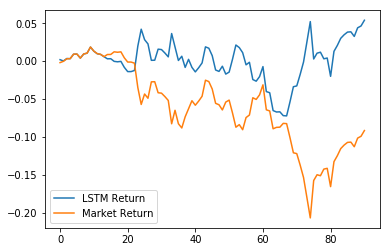

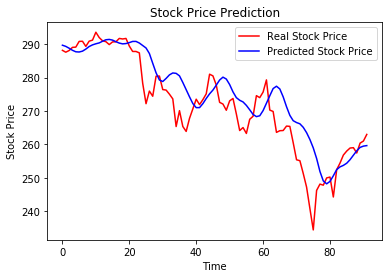

Market return -9.2 %
Model return 5.4 %

train MSE 0.0008448990050054627
test MSE 0.004255342459225137

Model Run Time:  1554393386.2492368
Final Accuracy:  0.4673913043478261



In [116]:
score = getScore(x_test, model, sc, test_targets)

test_mse=model.evaluate(x_test,y_test,verbose=0)
train_mse=model.evaluate(x_train,y_train,verbose=0)
print('train MSE', train_mse)
print('test MSE', test_mse)
end = time.time()

print()
print('Model Run Time: ', end- start)
print('Final Accuracy: ', score)
print()